In [33]:
import pandas as pd
import os 
import matplotlib.pyplot as plt



In [2]:
import constants as c

#DRE
dre_dir = c.dre_dir

dres = dict()

codigos = [f for f in os.listdir(dre_dir) if os.path.isdir(os.path.join(dre_dir, f))]
for cod in codigos:
    # get only file inside cod
    file = [f for f in os.listdir(f"{dre_dir}{cod}/") if os.path.isfile(os.path.join(f"{dre_dir}{cod}/", f))][0]
    path = f"{dre_dir}{cod}/{file}"
    dres[int(cod)] = pd.read_csv(path)
    
essential_cols_dre = [
        ' Receita de Venda de Bens e/ou Serviços ', ' Resultado Bruto ', ' Custo dos Bens e/ou Serviços Vendidos ',
        ' Despesas/Receitas Operacionais ', ' Resultado Antes do Resultado Financeiro e dos Tributos ',
        ' Resultado Financeiro ', ' Resultado Antes dos Tributos sobre o Lucro ', ' Imposto de Renda e Contribuição Social sobre o Lucro ',
        ' Resultado Líquido das Operações Continuadas ', ' Lucro/Prejuízo Consolidado do Período ',
    ]

valid_dres = dict()

for dre_cod in dres:
    dre = dres[dre_cod]
    # print(dre.head())
    if not ' Descrição ' in dre.columns: continue

    contas = dre[' Descrição ']

    # discards banks and other tickers that do not have ' Receita de Venda de Bens e/ou Serviços '
    if ' Receitas da Intermediação Financeira ' in contas.values: 
        continue
    if not ' Receita de Venda de Bens e/ou Serviços ' in contas.values:
        continue


    invalid = False
    for attr in essential_cols_dre:
        for c in ['01/01/2019 a 31/12/2019 ', '01/01/2020 a 31/12/2020 ', '01/01/2021 a 31/12/2021 ']:
            # remove the ones without any of the essential cols
            rec = dre[dre[' Descrição '] == attr]
            if not c in rec or len(rec[c].values) == 0:
                invalid = True
                break
            receita = rec[c].values[0].replace(' ', '')
            if receita == '': 
                invalid = True
                break
    if invalid: continue
    
    valid_dres[dre_cod] = dre

print(f'{len(valid_dres)} valid DREs')

268 valid DREs


In [3]:
import constants as c
bpa_dir = c.bpa_dir

bpas = dict()

codigos = [f for f in os.listdir(bpa_dir) if os.path.isdir(os.path.join(bpa_dir, f))]
for cod in codigos:
    file = [f for f in os.listdir(f"{bpa_dir}{cod}/") if os.path.isfile(os.path.join(f"{bpa_dir}{cod}/", f))][0]
    path = f"{bpa_dir}{cod}/{file}"
    bpas[int(cod)] = pd.read_csv(path)

essential_cols_bpa = [
        ' Ativo Total ', ' Ativo Circulante ', ' Ativo Não Circulante ', ' Caixa e Equivalentes de Caixa ', ' Contas a Receber ',
        ' Ativo Realizável a Longo Prazo ', ' Imobilizado ',
    ]

valid_bpas = dict()

for bpa_cod in bpas:
    bpa = bpas[bpa_cod]
    if not ' Descrição ' in bpa.columns: continue

    contas = bpa[' Descrição ']

    invalid = False
    for attr in essential_cols_bpa:
        for c in [' 31/12/2019 ', ' 31/12/2020 ', ' 31/12/2021 ']:
            # remove the ones without any of the essential cols
            rec = bpa[bpa[' Descrição '] == attr]
            if not c in rec or len(rec[c].values) == 0:
                invalid = True
                break
            receita = rec[c].values[0].replace(' ', '')
            if receita == '': 
                invalid = True
                break
    if invalid: continue
    
    valid_bpas[bpa_cod] = bpa

print(f'{len(valid_bpas)} valid bpas')

371 valid bpas


In [4]:
market_caps = pd.read_csv('market_caps.csv')
cvm_to_ticker = pd.read_csv('cvm_to_ticker.csv')

market_caps
cvm_to_ticker

mc = dict()

for t in market_caps['Ticker']:
    cvm = cvm_to_ticker[cvm_to_ticker['Ticker'] == t]['CVM'].values[0]
    mc[cvm] = {
        'ticker': t,
        'market_cap': market_caps[market_caps['Ticker'] == t]
    }

valid_keys = mc.keys() & valid_dres.keys() & valid_bpas.keys()
print(len(valid_keys))

103


In [5]:

dre_fields_col = []

for dre_cod in valid_keys:
    dre = valid_dres[dre_cod]
    bpa = valid_bpas[dre_cod]

    
    for year in [2019]:
        dre_fields = dict()
        dre_fields['cod'] = dre_cod
        for e in essential_cols_dre:
            conta_row = dre[dre[' Descrição '] == e]
            e = e.replace(' ', '').replace('/', '').lower()
            dre_fields[e] = conta_row[f'01/01/{year} a 31/12/{year} '].values[0].replace(' ', '')
        for e in essential_cols_bpa:
            conta_row = bpa[bpa[' Descrição '] == e]
            e = e.replace(' ', '').replace('/', '').lower()
            dre_fields[e] = conta_row[f' 31/12/{year} '].values[0].replace(' ', '')
        dre_fields['mc'] = mc[dre_cod]['market_cap'][f'{year} MC'].values[0]
        dre_fields_col.append(dre_fields)


df = pd.DataFrame(dre_fields_col)
df

,cod,receitadevendadebenseouserviços,resultadobruto,custodosbenseouserviçosvendidos,despesasreceitasoperacionais,resultadoantesdoresultadofinanceiroedostributos,resultadofinanceiro,resultadoantesdostributossobreolucro,impostoderendaecontribuiçãosocialsobreolucro,resultadolíquidodasoperaçõescontinuadas,lucroprejuízoconsolidadodoperíodo,ativototal,ativocirculante,ativonãocirculante,caixaeequivalentesdecaixa,contasareceber,ativorealizávelalongoprazo,imobilizado,mc
0,21008,139215,102756,-36459,14345,117101,-144231,-27130,-7182,-34312,-34312,1699421,357425,1341996,197654,56155,362589,18127,1.890328e+08
1,19992,2282124,1472630,-809494,-1147426,325204,-1177,324027,-70111,253916,210648,3535927,2004275,1531652,1538156,350995,328403,389432,1.284573e+10
2,21016,3565036,2044318,-1520718,-1144300,900018,-242090,657928,-11788,646140,646140,5512492,1475684,4036808,12251,759622,693832,1732222,1.386361e+10
3,1562,149310,77286,-72024,-69103,8183,1245,9428,-5234,4194,4194,190587,111867,78720,5661,30886,43916,29673,1.003346e+08
4,18465,89297975,6110866,-83187109,-4822459,1288407,-506854,781553,-378609,402944,402944,31195472,15058055,16137417,2115379,4112417,4639531,9553674,2.640835e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,14320,14948719,1874590,-13074129,-922079,952511,-509839,442672,-65981,376691,376691,26337032,8861282,17475750,1252966,1938440,4180797,11424691,1.149094e+10
99,22519,316225,109243,-206982,-235888,-126645,-5183,-131828,9174,-122654,-122654,676091,392740,283351,54109,154790,51918,38992,2.562034e+08
100,22012,439465,156972,-282493,-199960,-42988,-14056,-57044,12064,-44980,-44980,1375895,306004,1069891,124910,116803,321974,576575,2.482665e+09
101,19453,3952889,1503882,-2449007,-708186,795696,-700072,95624,-280904,-185280,-185460,11542453,2327040,9215413,1856248,177757,775819,545424,1.133862e+10


In [6]:
import numpy as np
from sklearn.linear_model import LinearRegression

X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]


In [15]:
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.8604728126287191

In [16]:
predicted = reg.predict(X)
bigger = 0
selected_tickers = []
for i in range(len(predicted)):
    if predicted[i] > y[i]*10.0:
        bigger += 1
        selected_tickers.append(mc[X.iloc[i]['cod']]['ticker'])
print(f'{bigger} bigger')
print(f'total: {len(predicted)}')
selected_tickers

25 bigger
total: 103


['GSHP3',
 'BALM3',
 'CAMB3',
 'HAGA3',
 'MSPA3',
 'PATI3',
 'EMAE3',
 'EPAR3',
 'CALI3',
 'FRIO3',
 'CRDE3',
 'MWET3',
 'DEXP3',
 'UCAS3',
 'EALT3',
 'WLMM3',
 'NUTR3',
 'OSXB3',
 'TXRX3',
 'TPIS3',
 'MNPR3',
 'TEKA3',
 'PDTC3',
 'BDLL3',
 'TECN3']

Return 2020: 169.275761733296%
Return 2021: 114.7191783757712%
2019-2020: 68.0% positives
2019-2021: 64.0% positives


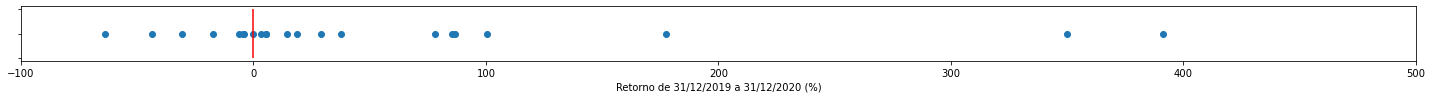

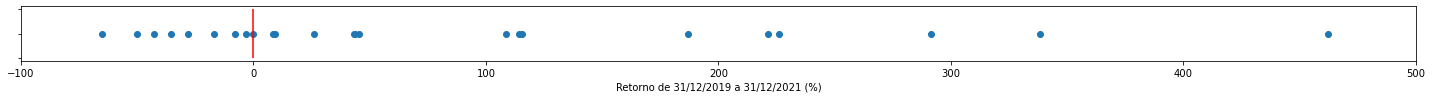

In [65]:
invested = len(selected_tickers)
final_value_2020 = 0
final_value_2021 = 0

map_2021 = dict()
map_2020 = dict()

for ticker in selected_tickers:
    cod_cvm = cvm_to_ticker[cvm_to_ticker['Ticker'] == ticker]['CVM'].values[0]
    
    return_this_2021 = mc[cod_cvm]['market_cap']['2021 MC'].values[0] / mc[cod_cvm]['market_cap']['2019 MC'].values[0]
    return_this_2020 =  mc[cod_cvm]['market_cap']['2020 MC'].values[0] / mc[cod_cvm]['market_cap']['2019 MC'].values[0]
    final_value_2020 += (return_this_2020)
    final_value_2021 += (return_this_2021)

    map_2020[ticker] = (return_this_2020-1) * 100
    map_2021[ticker] = (return_this_2021-1) * 100

return_2020 = (final_value_2020/invested - 1) * 100
return_2021 = (final_value_2021/invested - 1) * 100
print(f'Return 2020: {return_2020}%')
print(f'Return 2021: {return_2021}%')

def print_stats(map, until):

    positives = 0
    negatives = 0
    for ticker in map:
        val = map[ticker]
        if val > 0:
            positives += 1
        else:
            negatives += 1

    print(f'2019-{until}: {(positives/(positives+negatives))*100}% positives')

    fig, ax = plt.subplots(figsize=(25,1))
    ax.set_xlabel(f'Retorno de 31/12/2019 a 31/12/{until} (%)')
    ax.set_ylabel('')
    ax.set_xlim([-100, 500])
    ax.vlines(0,-1,1, colors='red')
    ax.tick_params(labelleft=False)    
    ax.scatter([map[x] for x in map], [0 for x in map], label=f'Return {until}')

print_stats(map_2020, 2020)
print_stats(map_2021, 2021)